In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from time import time
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats
from scipy.stats import f
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from arch.unitroot import PhillipsPerron
from statsmodels.tsa.stattools import adfuller, kpss
import pmdarima as pm
from pmdarima import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
#  Read the data and derive information about it
data = pd.read_excel('data_name_aqi.xlsx')
data.info()
data.describe()
# Calculate missing values
missing_count = data.isnull().sum()
missing_percentage = data.isnull().mean() * 100 
valid_counts = data.notnull().sum()
missing_stats = pd.DataFrame({
    'Missing Count': missing_count, 
    'Missing Percentage': missing_percentage, 
    'Valid Counts': valid_counts
})
missing_stats

data.interpolate(method='linear', inplace=True)

for column in data.columns:
    if pd.isnull(data[column].iloc[0]):
        data[column].iloc[0] = data[column].bfill().iloc[0]
    if pd.isnull(data[column].iloc[-1]):
        data[column].iloc[-1] = data[column].ffill().iloc[-1]
        # Check for missing values
missing_count = data.isnull().sum()
print (missing_count)
# Ensure 'date' is in datetime format and sort by date
data['date'] = pd.to_datetime(data['date'])
data.sort_values('date', inplace=True)

# Check initial data shape
initial_shape = data.shape[0]

# Use shift to create the target column for next day's AQI
data['Next_Day_AQI'] = data['AQI'].shift(-1)

# Check how many rows will have NaN in 'Next_Day_AQI' (should be only the last one)
nan_in_target = data['Next_Day_AQI'].isna().sum()

# Drop the rows where 'Next_Day_AQI' is NaN (typically just the last row)
data.dropna(subset=['Next_Day_AQI'], inplace=True)

# Final data shape after dropping NaN in 'Next_Day_AQI'
final_shape = data.shape[0]

# Output the initial and final data shapes and the count of NaN in 'Next_Day_AQI'
initial_shape, final_shape, nan_in_target
data.describe()
print(data.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1461 non-null   datetime64[ns]
 1   temperature           1452 non-null   float64       
 2   atmospheric_pressure  1452 non-null   float64       
 3   relative_humidity     1452 non-null   float64       
 4   precipitation         1461 non-null   float64       
 5   wind_speed            1452 non-null   float64       
 6   CO                    1461 non-null   float64       
 7   NO2                   1461 non-null   int64         
 8   O3                    1461 non-null   int64         
 9   PM10                  1461 non-null   int64         
 10  PM2.5                 1461 non-null   int64         
 11  SO2                   1461 non-null   int64         
 12  AQI                   1461 non-null   int64         
dtypes: datetime64[ns](

In [3]:
# Ensure 'date' is in datetime format and sort by date
data['date'] = pd.to_datetime(data['date'])
data.sort_values('date', inplace=True)

# Set 'date' as the index
data.set_index('date', inplace=True)

In [4]:
split_point = int(len(data) * 0.75)  
train_data = data.iloc[:split_point]
test_data = data.iloc[split_point:]

# 5个变量

In [5]:
train_x = train_data.drop(['AQI', 'Next_Day_AQI','CO', 'NO2', 'O3', 'PM10', 'PM2.5',
       'SO2'], axis=1)
train_y = train_data['Next_Day_AQI']
test_x = test_data.drop(['AQI', 'Next_Day_AQI','CO', 'NO2', 'O3', 'PM10', 'PM2.5',
       'SO2'], axis=1)
test_y = test_data['Next_Day_AQI']
print(train_x.columns)

Index(['temperature', 'atmospheric_pressure', 'relative_humidity',
       'precipitation', 'wind_speed'],
      dtype='object')


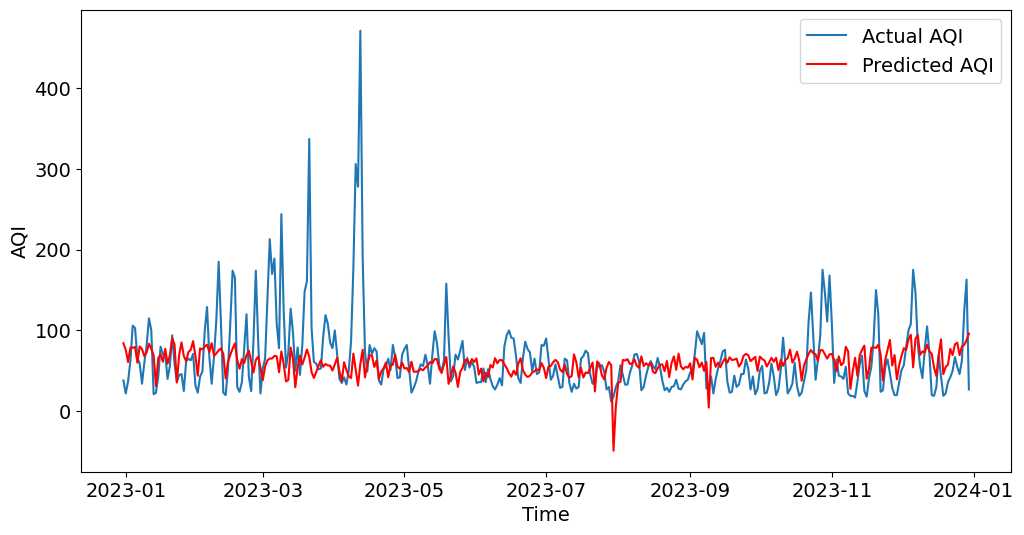

In [6]:
model = LinearRegression()
model.fit(train_x, train_y)
pred_y = model.predict(test_x)

plt.figure(figsize=(12, 6))
plt.plot(test_y.index, test_y.values, label='Actual AQI')
plt.plot(test_y.index, pred_y, label='Predicted AQI', color='red')

plt.xlabel('Time', fontsize=14)  
plt.ylabel('AQI', fontsize=14)
plt.tick_params(axis='x', labelsize=14)  
plt.tick_params(axis='y', labelsize=14)  

plt.legend(fontsize=14) 
plt.title('')
plt.grid(False)  

output_path = 'C:/Users/Liu/Downloads/8_dissertation/LR_.png'
plt.savefig(output_path)
plt.show()


In [7]:
train_x_with_const = sm.add_constant(train_x)

model = sm.OLS(train_y, train_x_with_const)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           Next_Day_AQI   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     25.09
Date:                Tue, 20 Aug 2024   Prob (F-statistic):           5.41e-24
Time:                        15:41:53   Log-Likelihood:                -5550.0
No. Observations:                1095   AIC:                         1.111e+04
Df Residuals:                    1089   BIC:                         1.114e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  872.8692 

In [8]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

train_x_with_const = sm.add_constant(train_x)
test_x_with_const = sm.add_constant(test_x)

model = sm.OLS(train_y, train_x_with_const)
results = model.fit()

print("R² on the testing data:")
print(results.rsquared) 
r2_test = results.rsquared_adj  
print(f"Adjusted R² on the testing data: {r2_test}")

pred_y = results.predict(test_x_with_const)

print("RMSE on the testing data:")
rmse = mean_squared_error(test_y, pred_y, squared=False)
print(rmse)

print("MSE on the testing data:")
mse = mean_squared_error(test_y, pred_y)
print(mse)

print("MAE on the testing data:")
mae = mean_absolute_error(test_y, pred_y)
print(mae)

R² on the testing data:
0.10328790564719681
Adjusted R² on the testing data: 0.09917077022776244
RMSE on the testing data:
47.94011014436669
MSE on the testing data:
2298.25416065401
MAE on the testing data:
30.004038153914895


E:\python\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


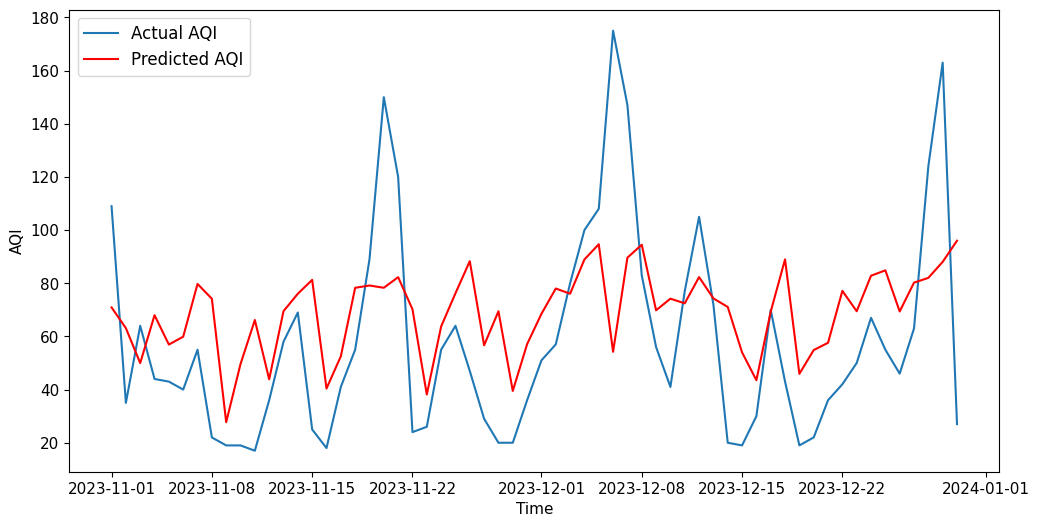

In [9]:
last_60_days_index = test_y.index[-60:]
last_60_days_actual = test_y[-60:]
last_60_days_pred = pred_y[-60:]

plt.figure(figsize=(12, 6))
plt.plot(last_60_days_index, last_60_days_actual, label='Actual AQI')
plt.plot(last_60_days_index, last_60_days_pred, label='Predicted AQI', color='red', marker='')

plt.xlabel('Time', fontsize=11)  
plt.ylabel('AQI', fontsize=11) 
plt.tick_params(axis='x', labelsize=11) 
plt.tick_params(axis='y', labelsize=11) 

plt.legend(fontsize=12)  
plt.grid(False) 

output_path = 'C:/Users/Liu/Downloads/8_dissertation/LR_60.png'
plt.savefig(output_path)
plt.show()

In [10]:
train_x = train_data.drop(['AQI', 'Next_Day_AQI','temperature', 'atmospheric_pressure', 'relative_humidity',
       'precipitation', 'wind_speed'], axis=1)
train_y = train_data['Next_Day_AQI']
test_x = test_data.drop(['AQI', 'Next_Day_AQI','temperature', 'atmospheric_pressure', 'relative_humidity',
       'precipitation', 'wind_speed'], axis=1)
test_y = test_data['Next_Day_AQI']
print(train_x.columns)

Index(['CO', 'NO2', 'O3', 'PM10', 'PM2.5', 'SO2'], dtype='object')


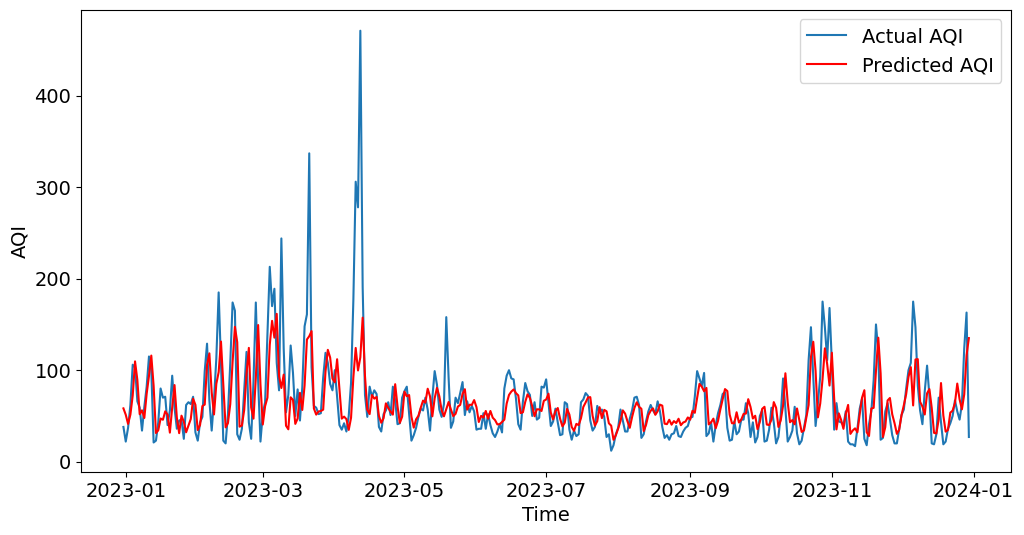

In [11]:
model = LinearRegression()
model.fit(train_x, train_y)

pred_y = model.predict(test_x)

plt.figure(figsize=(12, 6))
plt.plot(test_y.index, test_y.values, label='Actual AQI')
plt.plot(test_y.index, pred_y, label='Predicted AQI', color='red')

plt.xlabel('Time', fontsize=14) 
plt.ylabel('AQI', fontsize=14) 
plt.tick_params(axis='x', labelsize=14) 
plt.tick_params(axis='y', labelsize=14) 

plt.legend(fontsize=14) 
plt.title('')
plt.grid(False)

output_path = 'C:/Users/Liu/Downloads/8_dissertation/LR_1.png'
plt.savefig(output_path)
plt.show()

In [12]:
train_x_with_const = sm.add_constant(train_x)

model = sm.OLS(train_y, train_x_with_const)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           Next_Day_AQI   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     132.9
Date:                Tue, 20 Aug 2024   Prob (F-statistic):          3.23e-126
Time:                        15:41:53   Log-Likelihood:                -5308.6
No. Observations:                1095   AIC:                         1.063e+04
Df Residuals:                    1088   BIC:                         1.067e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.8034      3.943      3.754      0.0

In [13]:
train_x_with_const = sm.add_constant(train_x)
test_x_with_const = sm.add_constant(test_x)

model = sm.OLS(train_y, train_x_with_const)
results = model.fit()

print("R² on the testing data:")
print(results.rsquared) 
r2_test = results.rsquared_adj  
print(f"Adjusted R² on the testing data: {r2_test}")

pred_y = results.predict(test_x_with_const)

print("RMSE on the testing data:")
rmse = mean_squared_error(test_y, pred_y, squared=False)
print(rmse)

print("MSE on the testing data:")
mse = mean_squared_error(test_y, pred_y)
print(mse)

print("MAE on the testing data:")
mae = mean_absolute_error(test_y, pred_y)
print(mae)

R² on the testing data:
0.4229961095182947
Adjusted R² on the testing data: 0.41981410276931463
RMSE on the testing data:
38.307422405448534
MSE on the testing data:
1467.4586113494604
MAE on the testing data:
22.626528878051126


E:\python\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


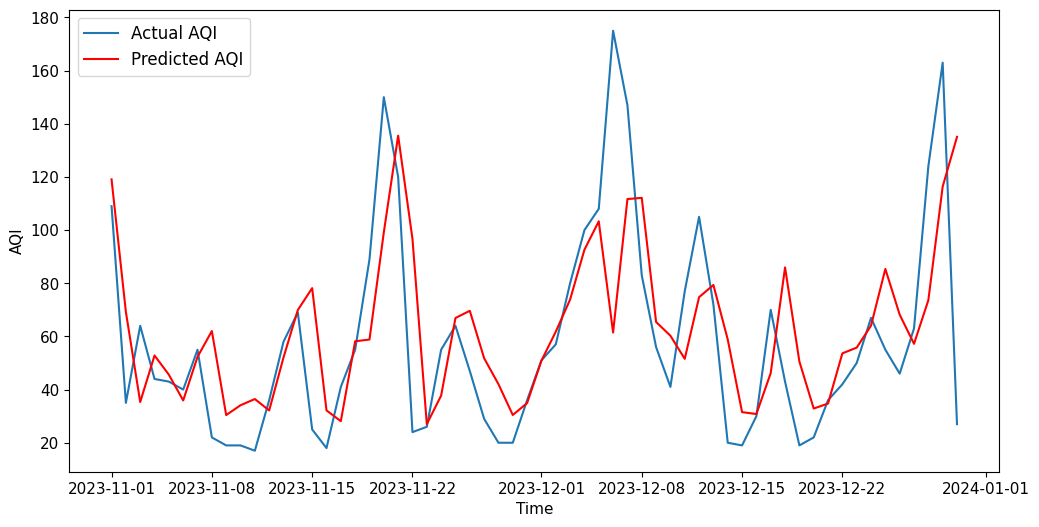

In [46]:
last_60_days_index = test_y.index[-60:]
last_60_days_actual = test_y[-60:]
last_60_days_pred = pred_y[-60:]

plt.figure(figsize=(12, 6))
plt.plot(last_60_days_index, last_60_days_actual, label='Actual AQI')
plt.plot(last_60_days_index, last_60_days_pred, label='Predicted AQI', color='red', marker='')

plt.xlabel('Time', fontsize=11) 
plt.ylabel('AQI', fontsize=11) 
plt.tick_params(axis='x', labelsize=11) 
plt.tick_params(axis='y', labelsize=11) 

plt.legend(fontsize=12)  
plt.grid(False) 

output_path = 'C:/Users/Liu/Downloads/8_dissertation/LR_60_1.png'
plt.savefig(output_path)
plt.show()
